In [1]:
import os 
os.listdir('../')
# train and test images are in differant folders (not included in the github repo )
# i put them in the upper folder containing them


# IMPORTANT ! 
image_directory = "../"   # change this to "./" if your images are in the same directory

In [2]:
import pandas as pd 
df = pd.read_csv("./license_plates_detection_train.csv")
df.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [3]:
l = df.loc[0,:]
l

img_id    1.jpg
ymin        276
xmin         94
ymax        326
xmax        169
Name: 0, dtype: object

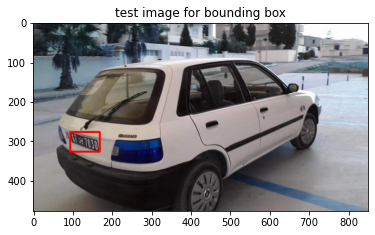

In [4]:
import cv2  #pip install opencv-python
import matplotlib.pyplot as plt 
img = cv2.imread(image_directory+"license_plates_detection_train/1.jpg")
cv2.rectangle(img,(l[2],l[1]),(l[4],l[3]),(255,0,0),3)
plt.imshow(img)
plt.title("test image for bounding box")
plt.show()

In [5]:
def convert_img_directory(img_name):
    return image_directory+"license_plates_detection_train/"+img_name
def show_bb(line_from_df):
    l = df.iloc[line_from_df,:]
    #change this if the train and test folder are somewhere else
    img = cv2.imread(convert_img_directory(l[0]))
    cv2.rectangle(img,(l[2],l[1]),(l[4],l[3]),(255,0,0),3)
    plt.imshow(img)
    plt.title("test image for bounding box")
    plt.show()

In [6]:
len(df)

900

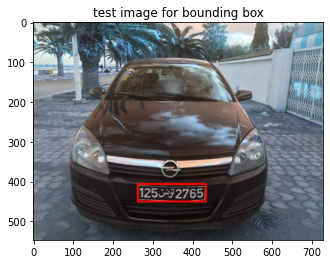

In [7]:
#pick any number under 900 from df
show_bb(2)